# Homework 5

*12232509 FAN Qingyuan*

Reproduce LeNet-5 by PyTorch, and divide the MNIST dataset into training set, validation set, and test set in a reasonable proportion. Train the LeNet-5, test it on the test set after training, and then compute the accuracy of the test result. In addition, write 20 handwritten digits by yourself and test them, outputting the accuracy of the test.



To reproduce LeNet-5, first we need to import the necessary packages including torch, torchvision, numpy and matplotlib. We also use tensorboard to log the training process.

In [1]:
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import math
import matplotlib.pyplot as plt
writer = SummaryWriter()

# use manual seed to reproduce the results
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [2]:
# create a LeNet-5 by PyTorch using nn.Sequential
class LeNet5Sequential(torch.nn.Module):
    def __init__(self):
        super(LeNet5Sequential, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, padding=2),
            torch.nn.Sigmoid(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Sigmoid(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(16 * 5 * 5, 120),
            torch.nn.Sigmoid(),
            torch.nn.Linear(120, 84),
            torch.nn.Sigmoid(),
            torch.nn.Linear(84, 10),
        )

    def forward(self, x):
        return self.model(x)


# Load datasets
You may skip this chapter if you only want to test the model.

In [3]:
# load the MNIST dataset
from torchvision import datasets, transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_val_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
# select 10% data for validation
train_len = int(0.9 * len(train_val_dataset))
val_len = len(train_val_dataset) - train_len
trainset, valset = torch.utils.data.random_split(
    train_val_dataset, [train_len, val_len]
)
testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

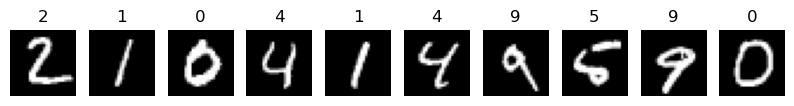

In [4]:
# plot some images from the dataset to see what they look like
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
for i in range(1, 11):
    ax = fig.add_subplot(1, 10, i)
    ax.imshow(testset.data[i], cmap='gray')
    ax.set_title(testset.targets[i].item())
    ax.axis('off')

In [5]:
# train the LeNet-5 model
def train(
    model, trainset, valset, batch_size=64, epochs=10, learning_rate=0.01, device="cpu"
):
    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # create the data loader
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False
    )

    # train the model
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(trainloader):
            if device == "cuda":
                images = images.to("cuda")
                labels = labels.to("cuda")

            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # log the train loss using tensorboard
            writer.add_scalar("Loss/train", loss.item(), epoch * len(trainloader) + i)

            # print the loss
            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, epochs, i + 1, len(trainloader), loss.item()
                    )
                )

        # val the model
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valloader:
                if device == "cuda":
                    images = images.to("cuda")
                    labels = labels.to("cuda")
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            # log the train loss using tensorboard
            writer.add_scalar("Accuracy/validation", 100 * correct / total, epoch)
            print("Validation accuracy images: {} %".format(100 * correct / total))
        
    # save the last model
    torch.save(model.state_dict(), "model.ckpt")

In [6]:
# train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5Sequential().to(device)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)
train(model, trainset, valset, batch_size=256, epochs=100, learning_rate=0.1, device='cuda')

Epoch [1/100], Step [100/211], Loss: 2.3024
Epoch [1/100], Step [200/211], Loss: 2.3038
Validation accuracy images: 11.1 %
Epoch [2/100], Step [100/211], Loss: 2.3042
Epoch [2/100], Step [200/211], Loss: 2.3042
Validation accuracy images: 11.1 %
Epoch [3/100], Step [100/211], Loss: 2.2980
Epoch [3/100], Step [200/211], Loss: 2.3012
Validation accuracy images: 9.583333333333334 %
Epoch [4/100], Step [100/211], Loss: 2.3052
Epoch [4/100], Step [200/211], Loss: 2.3088
Validation accuracy images: 11.1 %
Epoch [5/100], Step [100/211], Loss: 2.2979
Epoch [5/100], Step [200/211], Loss: 2.2988
Validation accuracy images: 11.1 %
Epoch [6/100], Step [100/211], Loss: 2.3128
Epoch [6/100], Step [200/211], Loss: 2.2994
Validation accuracy images: 11.1 %
Epoch [7/100], Step [100/211], Loss: 2.3051
Epoch [7/100], Step [200/211], Loss: 2.3001
Validation accuracy images: 10.933333333333334 %
Epoch [8/100], Step [100/211], Loss: 2.3060
Epoch [8/100], Step [200/211], Loss: 2.3203
Validation accuracy imag

### Use test set to test the model

In [7]:
# test set accuracy
model.to('cpu')
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 98.15 %


In [11]:
# save model to file
torch.save(model.state_dict(), "model-256batch-98.15.pt")

## Verify the model using my own handwritten digits

In [12]:
# load model from file
model = LeNet5Sequential()
model.load_state_dict(torch.load("model-256batch-98.15.pt"))

<All keys matched successfully>

In [13]:
# load npy file
handwrite_test_imgs = np.load('spark_handwrite_test3.npy')

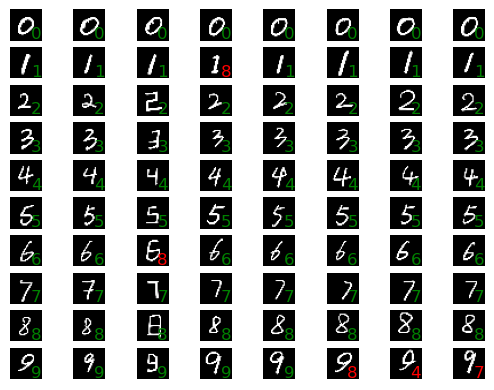

In [14]:
# use the model to predict the handwrite images and plot the prediction results
# put model in evaluation mode and to cpu
model.to('cpu')
model.eval()
corrected_sample_count = 0
with torch.no_grad():
    for i in range(handwrite_test_imgs.shape[0]):
        img = handwrite_test_imgs[i]
        img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()
        output = model(img)
        _, pred = torch.max(output, 1)
        plt.subplot(10, 8, i+1)
        # vertical space between subplots
        # plt.subplots_adjust(hspace=0)
        plt.imshow(handwrite_test_imgs[i], cmap='gray')
        # put the title to the bottom right corner inside the image, use white color
        # shift down the title a little bit
        if (int(pred.item()) != math.floor(i/8)):
            plt.title(pred.item(), loc='right', color='red', y=-0.2)
        else:
            plt.title(pred.item(), loc='right', color='green', y=-0.2)
            corrected_sample_count += 1
        plt.axis('off')

In [15]:
# print the accuracy for my own hanwrite datasets
print('Test Accuracy of the model on my own handwritten images: {} %'.format(100 * corrected_sample_count / handwrite_test_imgs.shape[0]))

Test Accuracy of the model on my own handwritten images: 93.75 %
